# Support Vector Machine for Infant Cry Classification

Implementasi SVM from scratch dengan algoritma Sequential Minimal Optimization (SMO) dan pendekatan One-vs-Rest untuk klasifikasi multiclass.

## Table of Contents
1. [Import Libraries & Setup](#1-import-libraries--setup)
2. [Load Dataset](#2-load-dataset)
3. [SVM Implementation](#3-svm-implementation)
4. [One-vs-Rest Implementation](#4-one-vs-rest-implementation)
5. [Hyperparameter Tuning](#5-hyperparameter-tuning)
6. [Model Training & Evaluation](#6-model-training--evaluation)
7. [Results Analysis](#7-results-analysis)
8. [Save Model](#8-save-model)

## 1. Import Libraries & Setup

In [1]:
%%time
# -*- coding: utf-8 -*-
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from itertools import product
import pickle
import time
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Set random seed untuk reproducibility
np.random.seed(42)

print("=" * 80)
print("SUPPORT VECTOR MACHINE FOR INFANT CRY CLASSIFICATION")
print("=" * 80)

SUPPORT VECTOR MACHINE FOR INFANT CRY CLASSIFICATION


## 2. Load Dataset

In [2]:
print("\n1. LOADING DATASET...")

# Load dataset
dataset_path = 'dataset_preprocessed/stage3/dataset.npz'
data = np.load(dataset_path, allow_pickle=True)

# Extract data
X_train = data['X_train']
X_val = data['X_val']
X_test = data['X_test']
y_train = data['y_train']
y_val = data['y_val']
y_test = data['y_test']
feature_names = data['feature_names']
label_mapping = data['label_mapping']

print("Dataset berhasil dimuat!")
print(f"Shape X_train: {X_train.shape}")
print(f"Shape X_val: {X_val.shape}")
print(f"Shape X_test: {X_test.shape}")
print(f"Jumlah fitur: {len(feature_names)}")
print(f"Label mapping: {label_mapping}")
print(f"Jumlah kelas: {len(np.unique(y_train))}")


1. LOADING DATASET...
Dataset berhasil dimuat!
Shape X_train: (1400, 34)
Shape X_val: (300, 34)
Shape X_test: (300, 34)
Jumlah fitur: 34
Label mapping: ['belly_pain' 'burping' 'discomfort' 'hungry' 'tired']
Jumlah kelas: 5


## 3. SVM Implementation

### 3.1 Kernel SVM dengan SMO Algorithm

In [3]:
print("\n2. IMPLEMENTASI SVM FROM SCRATCH...")

class KernelSVM:
    """
    Support Vector Machine dengan Sequential Minimal Optimization (SMO)
    """
    
    def __init__(self, C=1.0, kernel='linear', gamma=1.0, max_iter=1000, tol=1e-3, eps=1e-3):
        """
        Parameters:
        - C: parameter regularisasi
        - kernel: jenis kernel ('linear' atau 'rbf')
        - gamma: parameter untuk RBF kernel
        - max_iter: maksimum iterasi
        - tol: toleransi untuk konvergensi
        - eps: epsilon untuk SMO
        """
        self.C = C
        self.kernel = kernel
        self.gamma = gamma
        self.max_iter = max_iter
        self.tol = tol
        self.eps = eps
        
    def _kernel_function(self, x1, x2):
        """Menghitung kernel function"""
        if self.kernel == 'linear':
            return np.dot(x1, x2.T)
        elif self.kernel == 'rbf':
            # RBF kernel: exp(-gamma * ||x1 - x2||^2)
            if x1.ndim == 1:
                x1 = x1.reshape(1, -1)
            if x2.ndim == 1:
                x2 = x2.reshape(1, -1)
            
            sq_dists = np.sum((x1[:, np.newaxis] - x2[np.newaxis, :]) ** 2, axis=2)
            return np.exp(-self.gamma * sq_dists)
        else:
            raise ValueError("Kernel tidak didukung. Gunakan 'linear' atau 'rbf'")
    
    def _compute_kernel_matrix(self, X1, X2=None):
        """Menghitung kernel matrix"""
        if X2 is None:
            X2 = X1
        return self._kernel_function(X1, X2)


2. IMPLEMENTASI SVM FROM SCRATCH...


In [4]:
# Lanjutan KernelSVM - SMO Algorithm Methods
class KernelSVM(KernelSVM):  # Extend the previous class
    
    def _objective_function(self, i, j):
        """Menghitung objective function untuk pasangan alpha i dan j"""
        if i == j:
            return 0
        
        eta = self.K[i, i] + self.K[j, j] - 2 * self.K[i, j]
        if eta <= 0:
            return 0
        
        return eta
    
    def _select_second_alpha(self, i, E_i):
        """Memilih alpha kedua untuk optimasi"""
        max_step = 0
        j = -1
        E_j = 0
        
        # Cari alpha yang memberikan langkah terbesar
        for k in range(len(self.alphas)):
            if k == i:
                continue
            E_k = self._compute_error(k)
            step = abs(E_i - E_k)
            if step > max_step:
                max_step = step
                j = k
                E_j = E_k
        
        if j == -1:
            # Jika tidak ada yang cocok, pilih secara random
            j = np.random.choice([k for k in range(len(self.alphas)) if k != i])
            E_j = self._compute_error(j)
            
        return j, E_j
    
    def _compute_error(self, i):
        """Menghitung error untuk sample i"""
        prediction = np.sum(self.alphas * self.y * self.K[:, i]) + self.b
        return prediction - self.y[i]

In [5]:
# Lanjutan KernelSVM - Update Methods
class KernelSVM(KernelSVM):  # Extend the previous class
    
    def _update_alpha_pair(self, i, j):
        """Update pasangan alpha i dan j"""
        E_i = self._compute_error(i)
        E_j = self._compute_error(j)
        
        # Simpan nilai lama
        alpha_i_old = self.alphas[i]
        alpha_j_old = self.alphas[j]
        
        # Hitung batas L dan H
        if self.y[i] != self.y[j]:
            L = max(0, self.alphas[j] - self.alphas[i])
            H = min(self.C, self.C + self.alphas[j] - self.alphas[i])
        else:
            L = max(0, self.alphas[i] + self.alphas[j] - self.C)
            H = min(self.C, self.alphas[i] + self.alphas[j])
        
        if L == H:
            return 0
        
        # Hitung eta
        eta = self._objective_function(i, j)
        if eta <= 0:
            return 0
        
        # Update alpha_j
        self.alphas[j] = alpha_j_old + self.y[j] * (E_i - E_j) / eta
        
        # Clip alpha_j
        if self.alphas[j] > H:
            self.alphas[j] = H
        elif self.alphas[j] < L:
            self.alphas[j] = L
        
        # Cek apakah perubahan cukup signifikan
        if abs(self.alphas[j] - alpha_j_old) < self.eps:
            return 0
        
        # Update alpha_i
        self.alphas[i] = alpha_i_old + self.y[i] * self.y[j] * (alpha_j_old - self.alphas[j])
        
        # Update bias b
        b1 = self.b - E_i - self.y[i] * (self.alphas[i] - alpha_i_old) * self.K[i, i] - \
             self.y[j] * (self.alphas[j] - alpha_j_old) * self.K[i, j]
        
        b2 = self.b - E_j - self.y[i] * (self.alphas[i] - alpha_i_old) * self.K[i, j] - \
             self.y[j] * (self.alphas[j] - alpha_j_old) * self.K[j, j]
        
        if 0 < self.alphas[i] < self.C:
            self.b = b1
        elif 0 < self.alphas[j] < self.C:
            self.b = b2
        else:
            self.b = (b1 + b2) / 2
        
        return 1

In [6]:
# Lanjutan KernelSVM - Training dan Prediction Methods
class KernelSVM(KernelSVM):  # Extend the previous class
    
    def fit(self, X, y):
        """Training SVM menggunakan SMO algorithm"""
        self.X = X
        self.y = y.astype(float)
        n_samples = X.shape[0]
        
        # Inisialisasi
        self.alphas = np.zeros(n_samples)
        self.b = 0
        
        # Hitung kernel matrix
        self.K = self._compute_kernel_matrix(X)
        
        # SMO algorithm
        iteration = 0
        num_changed = 0
        examine_all = True
        
        while (num_changed > 0 or examine_all) and iteration < self.max_iter:
            num_changed = 0
            
            if examine_all:
                # Periksa semua sample
                for i in range(n_samples):
                    if self._examine_example(i):
                        num_changed += 1
            else:
                # Periksa hanya non-bound samples
                for i in range(n_samples):
                    if 0 < self.alphas[i] < self.C:
                        if self._examine_example(i):
                            num_changed += 1
            
            if examine_all:
                examine_all = False
            elif num_changed == 0:
                examine_all = True
            
            iteration += 1
        
        # Simpan support vectors
        support_vector_idx = self.alphas > self.eps
        self.support_vectors = X[support_vector_idx]
        self.support_vector_labels = y[support_vector_idx]
        self.support_vector_alphas = self.alphas[support_vector_idx]
        
        return self
    
    def _examine_example(self, i):
        """Periksa contoh i untuk optimasi"""
        E_i = self._compute_error(i)
        r_i = E_i * self.y[i]
        
        if (r_i < -self.tol and self.alphas[i] < self.C) or \
           (r_i > self.tol and self.alphas[i] > 0):
            
            # Pilih alpha kedua
            j, E_j = self._select_second_alpha(i, E_i)
            
            if self._update_alpha_pair(i, j):
                return True
        
        return False
    
    def predict(self, X):
        """Prediksi untuk data baru"""
        if not hasattr(self, 'support_vectors'):
            raise ValueError("Model belum di-training!")
        
        # Hitung kernel antara data baru dan support vectors
        K_pred = self._kernel_function(self.support_vectors, X)
        
        # Hitung prediksi
        predictions = np.sum(self.support_vector_alphas.reshape(-1, 1) * 
                           self.support_vector_labels.reshape(-1, 1) * K_pred, axis=0) + self.b
        
        return np.sign(predictions)
    
    def decision_function(self, X):
        """Menghitung decision function untuk data baru"""
        if not hasattr(self, 'support_vectors'):
            raise ValueError("Model belum di-training!")
        
        # Hitung kernel antara data baru dan support vectors
        K_pred = self._kernel_function(self.support_vectors, X)
        
        # Hitung decision function
        decision = np.sum(self.support_vector_alphas.reshape(-1, 1) * 
                         self.support_vector_labels.reshape(-1, 1) * K_pred, axis=0) + self.b
        
        return decision

print("✅ Implementasi KernelSVM selesai!")

✅ Implementasi KernelSVM selesai!


## 4. One-vs-Rest Implementation

### 4.1 One-vs-Rest SVM untuk Multiclass Classification

In [7]:
print("\n3. IMPLEMENTASI ONE-VS-REST...")

class OneVsRestSVM:
    """
    One-vs-Rest SVM untuk klasifikasi multiclass
    """
    
    def __init__(self, C=1.0, kernel='linear', gamma=1.0, max_iter=1000, tol=1e-3, eps=1e-3):
        """
        Parameters sama dengan KernelSVM
        """
        self.C = C
        self.kernel = kernel
        self.gamma = gamma
        self.max_iter = max_iter
        self.tol = tol
        self.eps = eps
        self.classifiers = {}
        
    def fit(self, X, y):
        """
        Training One-vs-Rest SVM
        """
        self.classes = np.unique(y)
        self.n_classes = len(self.classes)
        
        print(f"Training {self.n_classes} binary classifiers...")
        
        # Training satu classifier untuk setiap kelas
        for i, class_label in enumerate(tqdm(self.classes, desc="Training classifiers")):
            # Buat binary labels: +1 untuk kelas saat ini, -1 untuk yang lain
            binary_y = np.where(y == class_label, 1, -1)
            
            # Training binary SVM
            classifier = KernelSVM(
                C=self.C,
                kernel=self.kernel,
                gamma=self.gamma,
                max_iter=self.max_iter,
                tol=self.tol,
                eps=self.eps
            )
            
            classifier.fit(X, binary_y)
            self.classifiers[class_label] = classifier
        
        return self
    
    def predict(self, X):
        """
        Prediksi menggunakan One-vs-Rest
        """
        if not self.classifiers:
            raise ValueError("Model belum di-training!")
        
        n_samples = X.shape[0]
        decision_scores = np.zeros((n_samples, self.n_classes))
        
        # Hitung decision function untuk setiap classifier
        for i, class_label in enumerate(self.classes):
            decision_scores[:, i] = self.classifiers[class_label].decision_function(X)
        
        # Pilih kelas dengan decision score tertinggi
        predicted_class_indices = np.argmax(decision_scores, axis=1)
        predictions = self.classes[predicted_class_indices]
        
        return predictions
    
    def predict_proba(self, X):
        """
        Prediksi probabilitas (menggunakan decision function sebagai proxy)
        """
        if not self.classifiers:
            raise ValueError("Model belum di-training!")
        
        n_samples = X.shape[0]
        decision_scores = np.zeros((n_samples, self.n_classes))
        
        # Hitung decision function untuk setiap classifier
        for i, class_label in enumerate(self.classes):
            decision_scores[:, i] = self.classifiers[class_label].decision_function(X)
        
        # Normalisasi menggunakan softmax
        exp_scores = np.exp(decision_scores - np.max(decision_scores, axis=1, keepdims=True))
        probabilities = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
        
        return probabilities

print("✅ Implementasi OneVsRestSVM selesai!")


3. IMPLEMENTASI ONE-VS-REST...
✅ Implementasi OneVsRestSVM selesai!


## 5. Hyperparameter Tuning

### 5.1 Grid Search Function

In [8]:
print("\n4. GRID SEARCH HYPERPARAMETER TUNING...")

def grid_search_svm(X_train, y_train, X_val, y_val, param_grid):
    """
    Grid search untuk finding best hyperparameters
    """
    best_score = 0
    best_params = None
    best_model = None
    results = []
    
    # Generate semua kombinasi parameter
    param_combinations = list(product(*param_grid.values()))
    param_names = list(param_grid.keys())
    
    print(f"Melakukan grid search dengan {len(param_combinations)} kombinasi parameter...")
    print(f"Parameter yang di-tune: {param_names}")
    
    for i, params in enumerate(tqdm(param_combinations, desc="Grid Search")):
        # Buat dictionary parameter
        current_params = dict(zip(param_names, params))
        
        try:
            # Training model dengan parameter saat ini
            model = OneVsRestSVM(**current_params)
            
            start_time = time.time()
            model.fit(X_train, y_train)
            train_time = time.time() - start_time
            
            # Evaluasi pada validation set
            y_pred = model.predict(X_val)
            score = accuracy_score(y_val, y_pred)
            
            # Simpan hasil
            result = {
                'params': current_params.copy(),
                'validation_accuracy': score,
                'train_time': train_time
            }
            results.append(result)
            
            # Update best model jika perlu
            if score > best_score:
                best_score = score
                best_params = current_params.copy()
                best_model = model
            
            print(f"\nKombinasi {i+1}/{len(param_combinations)}:")
            print(f"  Parameters: {current_params}")
            print(f"  Validation Accuracy: {score:.4f}")
            print(f"  Training Time: {train_time:.2f} seconds")
            
        except Exception as e:
            print(f"\nError pada kombinasi {i+1}: {current_params}")
            print(f"  Error: {str(e)}")
            continue
    
    print(f"\n{'='*80}")
    print("HASIL GRID SEARCH:")
    print(f"Best Validation Accuracy: {best_score:.4f}")
    print(f"Best Parameters: {best_params}")
    print(f"{'='*80}")
    
    return best_model, best_params, best_score, results

print("✅ Grid search function ready!")


4. GRID SEARCH HYPERPARAMETER TUNING...
✅ Grid search function ready!


### 5.2 Define Parameter Grids

In [9]:
# Parameter grid untuk linear kernel
linear_param_grid = {
    'kernel': ['linear'],
    'C': [0.1, 1.0, 10.0],
    'max_iter': [500, 1000],
    'tol': [1e-3, 1e-4],
    'eps': [1e-3, 1e-4],
    'gamma': [1.0]  # Tidak digunakan untuk linear, tapi perlu ada
}

# Parameter grid untuk RBF kernel
rbf_param_grid = {
    'kernel': ['rbf'],
    'C': [0.1, 1.0, 10.0],
    'gamma': [0.001, 0.01, 0.1],
    'max_iter': [500, 1000],
    'tol': [1e-3, 1e-4],
    'eps': [1e-3, 1e-4]
}

print("Grid search akan dilakukan dalam 2 tahap:")
print(f"1. Linear kernel: {np.prod([len(v) for v in linear_param_grid.values()])} kombinasi")
print(f"2. RBF kernel: {np.prod([len(v) for v in rbf_param_grid.values()])} kombinasi")

Grid search akan dilakukan dalam 2 tahap:
1. Linear kernel: 24 kombinasi
2. RBF kernel: 72 kombinasi


### 5.3 Execute Grid Search - Linear Kernel

In [10]:
print("\n5. EKSEKUSI GRID SEARCH...")
print("=" * 80)
print("GRID SEARCH - LINEAR KERNEL")
print("=" * 80)

best_linear_model, best_linear_params, best_linear_score, linear_results = grid_search_svm(
    X_train, y_train, X_val, y_val, linear_param_grid
)


5. EKSEKUSI GRID SEARCH...
GRID SEARCH - LINEAR KERNEL
Melakukan grid search dengan 24 kombinasi parameter...
Parameter yang di-tune: ['kernel', 'C', 'max_iter', 'tol', 'eps', 'gamma']


Grid Search:   0%|          | 0/24 [00:00<?, ?it/s]

Training 5 binary classifiers...


Grid Search:   4%|▍         | 1/24 [02:09<49:39, 129.52s/it]


Kombinasi 1/24:
  Parameters: {'kernel': 'linear', 'C': 0.1, 'max_iter': 500, 'tol': 0.001, 'eps': 0.001, 'gamma': 1.0}
  Validation Accuracy: 0.2700
  Training Time: 129.51 seconds
Training 5 binary classifiers...


Grid Search:   8%|▊         | 2/24 [04:16<46:51, 127.79s/it]


Kombinasi 2/24:
  Parameters: {'kernel': 'linear', 'C': 0.1, 'max_iter': 500, 'tol': 0.001, 'eps': 0.0001, 'gamma': 1.0}
  Validation Accuracy: 0.2700
  Training Time: 126.58 seconds
Training 5 binary classifiers...


Grid Search:  12%|█▎        | 3/24 [06:26<45:04, 128.78s/it]


Kombinasi 3/24:
  Parameters: {'kernel': 'linear', 'C': 0.1, 'max_iter': 500, 'tol': 0.0001, 'eps': 0.001, 'gamma': 1.0}
  Validation Accuracy: 0.2700
  Training Time: 129.95 seconds
Training 5 binary classifiers...


Grid Search:  17%|█▋        | 4/24 [08:46<44:26, 133.34s/it]


Kombinasi 4/24:
  Parameters: {'kernel': 'linear', 'C': 0.1, 'max_iter': 500, 'tol': 0.0001, 'eps': 0.0001, 'gamma': 1.0}
  Validation Accuracy: 0.2700
  Training Time: 140.31 seconds
Training 5 binary classifiers...


Grid Search:  21%|██        | 5/24 [11:15<43:59, 138.92s/it]


Kombinasi 5/24:
  Parameters: {'kernel': 'linear', 'C': 0.1, 'max_iter': 1000, 'tol': 0.001, 'eps': 0.001, 'gamma': 1.0}
  Validation Accuracy: 0.2700
  Training Time: 148.82 seconds
Training 5 binary classifiers...


Grid Search:  25%|██▌       | 6/24 [13:32<41:29, 138.29s/it]


Kombinasi 6/24:
  Parameters: {'kernel': 'linear', 'C': 0.1, 'max_iter': 1000, 'tol': 0.001, 'eps': 0.0001, 'gamma': 1.0}
  Validation Accuracy: 0.2700
  Training Time: 137.05 seconds
Training 5 binary classifiers...


Grid Search:  29%|██▉       | 7/24 [15:47<38:54, 137.32s/it]


Kombinasi 7/24:
  Parameters: {'kernel': 'linear', 'C': 0.1, 'max_iter': 1000, 'tol': 0.0001, 'eps': 0.001, 'gamma': 1.0}
  Validation Accuracy: 0.2700
  Training Time: 135.32 seconds
Training 5 binary classifiers...


Grid Search:  33%|███▎      | 8/24 [18:03<36:27, 136.72s/it]


Kombinasi 8/24:
  Parameters: {'kernel': 'linear', 'C': 0.1, 'max_iter': 1000, 'tol': 0.0001, 'eps': 0.0001, 'gamma': 1.0}
  Validation Accuracy: 0.2700
  Training Time: 135.42 seconds
Training 5 binary classifiers...


Grid Search:  38%|███▊      | 9/24 [21:34<40:02, 160.20s/it]


Kombinasi 9/24:
  Parameters: {'kernel': 'linear', 'C': 1.0, 'max_iter': 500, 'tol': 0.001, 'eps': 0.001, 'gamma': 1.0}
  Validation Accuracy: 0.2967
  Training Time: 211.81 seconds
Training 5 binary classifiers...


Grid Search:  42%|████▏     | 10/24 [25:12<41:33, 178.09s/it]


Kombinasi 10/24:
  Parameters: {'kernel': 'linear', 'C': 1.0, 'max_iter': 500, 'tol': 0.001, 'eps': 0.0001, 'gamma': 1.0}
  Validation Accuracy: 0.2967
  Training Time: 218.13 seconds
Training 5 binary classifiers...


Grid Search:  46%|████▌     | 11/24 [28:49<41:09, 190.00s/it]


Kombinasi 11/24:
  Parameters: {'kernel': 'linear', 'C': 1.0, 'max_iter': 500, 'tol': 0.0001, 'eps': 0.001, 'gamma': 1.0}
  Validation Accuracy: 0.3033
  Training Time: 216.99 seconds
Training 5 binary classifiers...


Grid Search:  50%|█████     | 12/24 [32:34<40:05, 200.44s/it]


Kombinasi 12/24:
  Parameters: {'kernel': 'linear', 'C': 1.0, 'max_iter': 500, 'tol': 0.0001, 'eps': 0.0001, 'gamma': 1.0}
  Validation Accuracy: 0.3033
  Training Time: 224.31 seconds
Training 5 binary classifiers...


Grid Search:  54%|█████▍    | 13/24 [36:10<37:37, 205.23s/it]


Kombinasi 13/24:
  Parameters: {'kernel': 'linear', 'C': 1.0, 'max_iter': 1000, 'tol': 0.001, 'eps': 0.001, 'gamma': 1.0}
  Validation Accuracy: 0.2967
  Training Time: 216.26 seconds
Training 5 binary classifiers...


Grid Search:  58%|█████▊    | 14/24 [39:42<34:32, 207.30s/it]


Kombinasi 14/24:
  Parameters: {'kernel': 'linear', 'C': 1.0, 'max_iter': 1000, 'tol': 0.001, 'eps': 0.0001, 'gamma': 1.0}
  Validation Accuracy: 0.2967
  Training Time: 212.05 seconds
Training 5 binary classifiers...


Grid Search:  62%|██████▎   | 15/24 [43:16<31:23, 209.28s/it]


Kombinasi 15/24:
  Parameters: {'kernel': 'linear', 'C': 1.0, 'max_iter': 1000, 'tol': 0.0001, 'eps': 0.001, 'gamma': 1.0}
  Validation Accuracy: 0.3033
  Training Time: 213.85 seconds
Training 5 binary classifiers...


Grid Search:  67%|██████▋   | 16/24 [46:54<28:14, 211.78s/it]


Kombinasi 16/24:
  Parameters: {'kernel': 'linear', 'C': 1.0, 'max_iter': 1000, 'tol': 0.0001, 'eps': 0.0001, 'gamma': 1.0}
  Validation Accuracy: 0.3033
  Training Time: 217.60 seconds
Training 5 binary classifiers...


Grid Search:  71%|███████   | 17/24 [1:01:54<48:51, 418.83s/it]


Kombinasi 17/24:
  Parameters: {'kernel': 'linear', 'C': 10.0, 'max_iter': 500, 'tol': 0.001, 'eps': 0.001, 'gamma': 1.0}
  Validation Accuracy: 0.3033
  Training Time: 900.31 seconds
Training 5 binary classifiers...


Grid Search:  75%|███████▌  | 18/24 [1:17:24<57:14, 572.36s/it]


Kombinasi 18/24:
  Parameters: {'kernel': 'linear', 'C': 10.0, 'max_iter': 500, 'tol': 0.001, 'eps': 0.0001, 'gamma': 1.0}
  Validation Accuracy: 0.2933
  Training Time: 929.76 seconds
Training 5 binary classifiers...


Grid Search:  79%|███████▉  | 19/24 [1:32:11<55:34, 666.86s/it]


Kombinasi 19/24:
  Parameters: {'kernel': 'linear', 'C': 10.0, 'max_iter': 500, 'tol': 0.0001, 'eps': 0.001, 'gamma': 1.0}
  Validation Accuracy: 0.2667
  Training Time: 886.97 seconds
Training 5 binary classifiers...


Grid Search:  83%|████████▎ | 20/24 [1:48:47<51:02, 765.66s/it]


Kombinasi 20/24:
  Parameters: {'kernel': 'linear', 'C': 10.0, 'max_iter': 500, 'tol': 0.0001, 'eps': 0.0001, 'gamma': 1.0}
  Validation Accuracy: 0.2433
  Training Time: 995.91 seconds
Training 5 binary classifiers...


Grid Search:  88%|████████▊ | 21/24 [2:04:24<40:51, 817.11s/it]


Kombinasi 21/24:
  Parameters: {'kernel': 'linear', 'C': 10.0, 'max_iter': 1000, 'tol': 0.001, 'eps': 0.001, 'gamma': 1.0}
  Validation Accuracy: 0.3033
  Training Time: 937.06 seconds
Training 5 binary classifiers...


Grid Search:  92%|█████████▏| 22/24 [2:20:09<28:31, 855.60s/it]


Kombinasi 22/24:
  Parameters: {'kernel': 'linear', 'C': 10.0, 'max_iter': 1000, 'tol': 0.001, 'eps': 0.0001, 'gamma': 1.0}
  Validation Accuracy: 0.2933
  Training Time: 945.31 seconds
Training 5 binary classifiers...


Grid Search:  96%|█████████▌| 23/24 [2:35:48<14:40, 880.66s/it]


Kombinasi 23/24:
  Parameters: {'kernel': 'linear', 'C': 10.0, 'max_iter': 1000, 'tol': 0.0001, 'eps': 0.001, 'gamma': 1.0}
  Validation Accuracy: 0.2667
  Training Time: 939.08 seconds
Training 5 binary classifiers...


Grid Search: 100%|██████████| 24/24 [2:51:48<00:00, 429.52s/it]


Kombinasi 24/24:
  Parameters: {'kernel': 'linear', 'C': 10.0, 'max_iter': 1000, 'tol': 0.0001, 'eps': 0.0001, 'gamma': 1.0}
  Validation Accuracy: 0.2433
  Training Time: 959.78 seconds

HASIL GRID SEARCH:
Best Validation Accuracy: 0.3033
Best Parameters: {'kernel': 'linear', 'C': 1.0, 'max_iter': 500, 'tol': 0.0001, 'eps': 0.001, 'gamma': 1.0}


### 5.4 Execute Grid Search - RBF Kernel

In [11]:
print("=" * 80)
print("GRID SEARCH - RBF KERNEL")
print("=" * 80)

best_rbf_model, best_rbf_params, best_rbf_score, rbf_results = grid_search_svm(
    X_train, y_train, X_val, y_val, rbf_param_grid
)

GRID SEARCH - RBF KERNEL
Melakukan grid search dengan 72 kombinasi parameter...
Parameter yang di-tune: ['kernel', 'C', 'gamma', 'max_iter', 'tol', 'eps']


Grid Search:   0%|          | 0/72 [00:00<?, ?it/s]

Training 5 binary classifiers...


Grid Search:   1%|▏         | 1/72 [02:28<2:55:39, 148.44s/it]


Kombinasi 1/72:
  Parameters: {'kernel': 'rbf', 'C': 0.1, 'gamma': 0.001, 'max_iter': 500, 'tol': 0.001, 'eps': 0.001}
  Validation Accuracy: 0.1900
  Training Time: 148.43 seconds
Training 5 binary classifiers...


Grid Search:   3%|▎         | 2/72 [04:57<2:53:16, 148.53s/it]


Kombinasi 2/72:
  Parameters: {'kernel': 'rbf', 'C': 0.1, 'gamma': 0.001, 'max_iter': 500, 'tol': 0.001, 'eps': 0.0001}
  Validation Accuracy: 0.1900
  Training Time: 148.57 seconds
Training 5 binary classifiers...


Grid Search:   4%|▍         | 3/72 [07:24<2:50:27, 148.22s/it]


Kombinasi 3/72:
  Parameters: {'kernel': 'rbf', 'C': 0.1, 'gamma': 0.001, 'max_iter': 500, 'tol': 0.0001, 'eps': 0.001}
  Validation Accuracy: 0.1900
  Training Time: 147.84 seconds
Training 5 binary classifiers...


Grid Search:   6%|▌         | 4/72 [09:53<2:48:09, 148.37s/it]


Kombinasi 4/72:
  Parameters: {'kernel': 'rbf', 'C': 0.1, 'gamma': 0.001, 'max_iter': 500, 'tol': 0.0001, 'eps': 0.0001}
  Validation Accuracy: 0.1900
  Training Time: 148.59 seconds
Training 5 binary classifiers...


Grid Search:   7%|▋         | 5/72 [12:22<2:46:08, 148.78s/it]


Kombinasi 5/72:
  Parameters: {'kernel': 'rbf', 'C': 0.1, 'gamma': 0.001, 'max_iter': 1000, 'tol': 0.001, 'eps': 0.001}
  Validation Accuracy: 0.1900
  Training Time: 149.49 seconds
Training 5 binary classifiers...


Grid Search:   8%|▊         | 6/72 [14:51<2:43:29, 148.64s/it]


Kombinasi 6/72:
  Parameters: {'kernel': 'rbf', 'C': 0.1, 'gamma': 0.001, 'max_iter': 1000, 'tol': 0.001, 'eps': 0.0001}
  Validation Accuracy: 0.1900
  Training Time: 148.34 seconds
Training 5 binary classifiers...


Grid Search:  10%|▉         | 7/72 [17:20<2:41:13, 148.82s/it]


Kombinasi 7/72:
  Parameters: {'kernel': 'rbf', 'C': 0.1, 'gamma': 0.001, 'max_iter': 1000, 'tol': 0.0001, 'eps': 0.001}
  Validation Accuracy: 0.1900
  Training Time: 149.19 seconds
Training 5 binary classifiers...


Grid Search:  11%|█         | 8/72 [19:48<2:38:32, 148.63s/it]


Kombinasi 8/72:
  Parameters: {'kernel': 'rbf', 'C': 0.1, 'gamma': 0.001, 'max_iter': 1000, 'tol': 0.0001, 'eps': 0.0001}
  Validation Accuracy: 0.1900
  Training Time: 148.21 seconds
Training 5 binary classifiers...


Grid Search:  12%|█▎        | 9/72 [22:10<2:33:43, 146.41s/it]


Kombinasi 9/72:
  Parameters: {'kernel': 'rbf', 'C': 0.1, 'gamma': 0.01, 'max_iter': 500, 'tol': 0.001, 'eps': 0.001}
  Validation Accuracy: 0.3633
  Training Time: 141.47 seconds
Training 5 binary classifiers...


Grid Search:  14%|█▍        | 10/72 [24:31<2:29:40, 144.84s/it]


Kombinasi 10/72:
  Parameters: {'kernel': 'rbf', 'C': 0.1, 'gamma': 0.01, 'max_iter': 500, 'tol': 0.001, 'eps': 0.0001}
  Validation Accuracy: 0.3633
  Training Time: 141.31 seconds
Training 5 binary classifiers...


Grid Search:  15%|█▌        | 11/72 [26:52<2:26:03, 143.66s/it]


Kombinasi 11/72:
  Parameters: {'kernel': 'rbf', 'C': 0.1, 'gamma': 0.01, 'max_iter': 500, 'tol': 0.0001, 'eps': 0.001}
  Validation Accuracy: 0.3633
  Training Time: 140.95 seconds
Training 5 binary classifiers...


Grid Search:  17%|█▋        | 12/72 [29:12<2:22:34, 142.58s/it]


Kombinasi 12/72:
  Parameters: {'kernel': 'rbf', 'C': 0.1, 'gamma': 0.01, 'max_iter': 500, 'tol': 0.0001, 'eps': 0.0001}
  Validation Accuracy: 0.3633
  Training Time: 140.07 seconds
Training 5 binary classifiers...


Grid Search:  18%|█▊        | 13/72 [31:34<2:20:00, 142.37s/it]


Kombinasi 13/72:
  Parameters: {'kernel': 'rbf', 'C': 0.1, 'gamma': 0.01, 'max_iter': 1000, 'tol': 0.001, 'eps': 0.001}
  Validation Accuracy: 0.3633
  Training Time: 141.86 seconds
Training 5 binary classifiers...


Grid Search:  19%|█▉        | 14/72 [33:55<2:17:16, 142.00s/it]


Kombinasi 14/72:
  Parameters: {'kernel': 'rbf', 'C': 0.1, 'gamma': 0.01, 'max_iter': 1000, 'tol': 0.001, 'eps': 0.0001}
  Validation Accuracy: 0.3633
  Training Time: 141.11 seconds
Training 5 binary classifiers...


Grid Search:  21%|██        | 15/72 [36:16<2:14:31, 141.60s/it]


Kombinasi 15/72:
  Parameters: {'kernel': 'rbf', 'C': 0.1, 'gamma': 0.01, 'max_iter': 1000, 'tol': 0.0001, 'eps': 0.001}
  Validation Accuracy: 0.3633
  Training Time: 140.61 seconds
Training 5 binary classifiers...


Grid Search:  22%|██▏       | 16/72 [38:38<2:12:22, 141.84s/it]


Kombinasi 16/72:
  Parameters: {'kernel': 'rbf', 'C': 0.1, 'gamma': 0.01, 'max_iter': 1000, 'tol': 0.0001, 'eps': 0.0001}
  Validation Accuracy: 0.3633
  Training Time: 142.36 seconds
Training 5 binary classifiers...


Grid Search:  24%|██▎       | 17/72 [40:52<2:07:49, 139.44s/it]


Kombinasi 17/72:
  Parameters: {'kernel': 'rbf', 'C': 0.1, 'gamma': 0.1, 'max_iter': 500, 'tol': 0.001, 'eps': 0.001}
  Validation Accuracy: 0.4433
  Training Time: 133.80 seconds
Training 5 binary classifiers...


Grid Search:  25%|██▌       | 18/72 [43:05<2:03:48, 137.56s/it]


Kombinasi 18/72:
  Parameters: {'kernel': 'rbf', 'C': 0.1, 'gamma': 0.1, 'max_iter': 500, 'tol': 0.001, 'eps': 0.0001}
  Validation Accuracy: 0.4433
  Training Time: 133.14 seconds
Training 5 binary classifiers...


Grid Search:  26%|██▋       | 19/72 [45:18<2:00:11, 136.06s/it]


Kombinasi 19/72:
  Parameters: {'kernel': 'rbf', 'C': 0.1, 'gamma': 0.1, 'max_iter': 500, 'tol': 0.0001, 'eps': 0.001}
  Validation Accuracy: 0.4433
  Training Time: 132.48 seconds
Training 5 binary classifiers...


Grid Search:  28%|██▊       | 20/72 [47:31<1:57:08, 135.17s/it]


Kombinasi 20/72:
  Parameters: {'kernel': 'rbf', 'C': 0.1, 'gamma': 0.1, 'max_iter': 500, 'tol': 0.0001, 'eps': 0.0001}
  Validation Accuracy: 0.4433
  Training Time: 133.04 seconds
Training 5 binary classifiers...


Grid Search:  29%|██▉       | 21/72 [49:45<1:54:30, 134.72s/it]


Kombinasi 21/72:
  Parameters: {'kernel': 'rbf', 'C': 0.1, 'gamma': 0.1, 'max_iter': 1000, 'tol': 0.001, 'eps': 0.001}
  Validation Accuracy: 0.4433
  Training Time: 133.60 seconds
Training 5 binary classifiers...


Grid Search:  31%|███       | 22/72 [51:58<1:51:52, 134.25s/it]


Kombinasi 22/72:
  Parameters: {'kernel': 'rbf', 'C': 0.1, 'gamma': 0.1, 'max_iter': 1000, 'tol': 0.001, 'eps': 0.0001}
  Validation Accuracy: 0.4433
  Training Time: 133.10 seconds
Training 5 binary classifiers...


Grid Search:  32%|███▏      | 23/72 [54:12<1:49:29, 134.07s/it]


Kombinasi 23/72:
  Parameters: {'kernel': 'rbf', 'C': 0.1, 'gamma': 0.1, 'max_iter': 1000, 'tol': 0.0001, 'eps': 0.001}
  Validation Accuracy: 0.4433
  Training Time: 133.60 seconds
Training 5 binary classifiers...


Grid Search:  33%|███▎      | 24/72 [56:25<1:47:13, 134.04s/it]


Kombinasi 24/72:
  Parameters: {'kernel': 'rbf', 'C': 0.1, 'gamma': 0.1, 'max_iter': 1000, 'tol': 0.0001, 'eps': 0.0001}
  Validation Accuracy: 0.4433
  Training Time: 133.91 seconds
Training 5 binary classifiers...


Grid Search:  35%|███▍      | 25/72 [58:52<1:47:54, 137.75s/it]


Kombinasi 25/72:
  Parameters: {'kernel': 'rbf', 'C': 1.0, 'gamma': 0.001, 'max_iter': 500, 'tol': 0.001, 'eps': 0.001}
  Validation Accuracy: 0.1900
  Training Time: 146.39 seconds
Training 5 binary classifiers...


Grid Search:  36%|███▌      | 26/72 [1:01:19<1:47:50, 140.67s/it]


Kombinasi 26/72:
  Parameters: {'kernel': 'rbf', 'C': 1.0, 'gamma': 0.001, 'max_iter': 500, 'tol': 0.001, 'eps': 0.0001}
  Validation Accuracy: 0.1900
  Training Time: 147.46 seconds
Training 5 binary classifiers...


Grid Search:  38%|███▊      | 27/72 [1:03:47<1:47:02, 142.71s/it]


Kombinasi 27/72:
  Parameters: {'kernel': 'rbf', 'C': 1.0, 'gamma': 0.001, 'max_iter': 500, 'tol': 0.0001, 'eps': 0.001}
  Validation Accuracy: 0.1900
  Training Time: 147.46 seconds
Training 5 binary classifiers...


Grid Search:  39%|███▉      | 28/72 [1:06:15<1:45:52, 144.38s/it]


Kombinasi 28/72:
  Parameters: {'kernel': 'rbf', 'C': 1.0, 'gamma': 0.001, 'max_iter': 500, 'tol': 0.0001, 'eps': 0.0001}
  Validation Accuracy: 0.1900
  Training Time: 148.26 seconds
Training 5 binary classifiers...


Grid Search:  40%|████      | 29/72 [1:08:42<1:44:03, 145.20s/it]


Kombinasi 29/72:
  Parameters: {'kernel': 'rbf', 'C': 1.0, 'gamma': 0.001, 'max_iter': 1000, 'tol': 0.001, 'eps': 0.001}
  Validation Accuracy: 0.1900
  Training Time: 147.07 seconds
Training 5 binary classifiers...


Grid Search:  42%|████▏     | 30/72 [1:11:10<1:42:08, 145.93s/it]


Kombinasi 30/72:
  Parameters: {'kernel': 'rbf', 'C': 1.0, 'gamma': 0.001, 'max_iter': 1000, 'tol': 0.001, 'eps': 0.0001}
  Validation Accuracy: 0.1900
  Training Time: 147.61 seconds
Training 5 binary classifiers...


Grid Search:  43%|████▎     | 31/72 [1:13:38<1:40:05, 146.47s/it]


Kombinasi 31/72:
  Parameters: {'kernel': 'rbf', 'C': 1.0, 'gamma': 0.001, 'max_iter': 1000, 'tol': 0.0001, 'eps': 0.001}
  Validation Accuracy: 0.1900
  Training Time: 147.73 seconds
Training 5 binary classifiers...


Grid Search:  44%|████▍     | 32/72 [1:16:05<1:37:54, 146.86s/it]


Kombinasi 32/72:
  Parameters: {'kernel': 'rbf', 'C': 1.0, 'gamma': 0.001, 'max_iter': 1000, 'tol': 0.0001, 'eps': 0.0001}
  Validation Accuracy: 0.1900
  Training Time: 147.75 seconds
Training 5 binary classifiers...


Grid Search:  46%|████▌     | 33/72 [1:18:21<1:33:14, 143.46s/it]


Kombinasi 33/72:
  Parameters: {'kernel': 'rbf', 'C': 1.0, 'gamma': 0.01, 'max_iter': 500, 'tol': 0.001, 'eps': 0.001}
  Validation Accuracy: 0.3533
  Training Time: 135.47 seconds
Training 5 binary classifiers...


Grid Search:  47%|████▋     | 34/72 [1:20:37<1:29:25, 141.19s/it]


Kombinasi 34/72:
  Parameters: {'kernel': 'rbf', 'C': 1.0, 'gamma': 0.01, 'max_iter': 500, 'tol': 0.001, 'eps': 0.0001}
  Validation Accuracy: 0.3533
  Training Time: 135.86 seconds
Training 5 binary classifiers...


Grid Search:  49%|████▊     | 35/72 [1:22:52<1:26:02, 139.53s/it]


Kombinasi 35/72:
  Parameters: {'kernel': 'rbf', 'C': 1.0, 'gamma': 0.01, 'max_iter': 500, 'tol': 0.0001, 'eps': 0.001}
  Validation Accuracy: 0.3533
  Training Time: 135.64 seconds
Training 5 binary classifiers...


Grid Search:  50%|█████     | 36/72 [1:25:07<1:22:54, 138.18s/it]


Kombinasi 36/72:
  Parameters: {'kernel': 'rbf', 'C': 1.0, 'gamma': 0.01, 'max_iter': 500, 'tol': 0.0001, 'eps': 0.0001}
  Validation Accuracy: 0.3533
  Training Time: 134.98 seconds
Training 5 binary classifiers...


Grid Search:  51%|█████▏    | 37/72 [1:27:24<1:20:18, 137.67s/it]


Kombinasi 37/72:
  Parameters: {'kernel': 'rbf', 'C': 1.0, 'gamma': 0.01, 'max_iter': 1000, 'tol': 0.001, 'eps': 0.001}
  Validation Accuracy: 0.3533
  Training Time: 136.42 seconds
Training 5 binary classifiers...


Grid Search:  53%|█████▎    | 38/72 [1:29:40<1:17:40, 137.07s/it]


Kombinasi 38/72:
  Parameters: {'kernel': 'rbf', 'C': 1.0, 'gamma': 0.01, 'max_iter': 1000, 'tol': 0.001, 'eps': 0.0001}
  Validation Accuracy: 0.3533
  Training Time: 135.63 seconds
Training 5 binary classifiers...


Grid Search:  54%|█████▍    | 39/72 [1:31:56<1:15:13, 136.77s/it]


Kombinasi 39/72:
  Parameters: {'kernel': 'rbf', 'C': 1.0, 'gamma': 0.01, 'max_iter': 1000, 'tol': 0.0001, 'eps': 0.001}
  Validation Accuracy: 0.3533
  Training Time: 136.05 seconds
Training 5 binary classifiers...


Grid Search:  56%|█████▌    | 40/72 [1:34:11<1:12:46, 136.44s/it]


Kombinasi 40/72:
  Parameters: {'kernel': 'rbf', 'C': 1.0, 'gamma': 0.01, 'max_iter': 1000, 'tol': 0.0001, 'eps': 0.0001}
  Validation Accuracy: 0.3533
  Training Time: 135.62 seconds
Training 5 binary classifiers...


Grid Search:  57%|█████▋    | 41/72 [1:36:03<1:06:36, 128.91s/it]


Kombinasi 41/72:
  Parameters: {'kernel': 'rbf', 'C': 1.0, 'gamma': 0.1, 'max_iter': 500, 'tol': 0.001, 'eps': 0.001}
  Validation Accuracy: 0.4600
  Training Time: 111.27 seconds
Training 5 binary classifiers...


Grid Search:  58%|█████▊    | 42/72 [1:37:54<1:01:48, 123.61s/it]


Kombinasi 42/72:
  Parameters: {'kernel': 'rbf', 'C': 1.0, 'gamma': 0.1, 'max_iter': 500, 'tol': 0.001, 'eps': 0.0001}
  Validation Accuracy: 0.4600
  Training Time: 111.18 seconds
Training 5 binary classifiers...


Grid Search:  60%|█████▉    | 43/72 [1:39:47<58:09, 120.34s/it]  


Kombinasi 43/72:
  Parameters: {'kernel': 'rbf', 'C': 1.0, 'gamma': 0.1, 'max_iter': 500, 'tol': 0.0001, 'eps': 0.001}
  Validation Accuracy: 0.4600
  Training Time: 112.67 seconds
Training 5 binary classifiers...


Grid Search:  61%|██████    | 44/72 [1:41:39<54:59, 117.84s/it]


Kombinasi 44/72:
  Parameters: {'kernel': 'rbf', 'C': 1.0, 'gamma': 0.1, 'max_iter': 500, 'tol': 0.0001, 'eps': 0.0001}
  Validation Accuracy: 0.4600
  Training Time: 111.95 seconds
Training 5 binary classifiers...


Grid Search:  62%|██████▎   | 45/72 [1:43:29<52:05, 115.74s/it]


Kombinasi 45/72:
  Parameters: {'kernel': 'rbf', 'C': 1.0, 'gamma': 0.1, 'max_iter': 1000, 'tol': 0.001, 'eps': 0.001}
  Validation Accuracy: 0.4600
  Training Time: 110.79 seconds
Training 5 binary classifiers...


Grid Search:  64%|██████▍   | 46/72 [1:45:21<49:32, 114.33s/it]


Kombinasi 46/72:
  Parameters: {'kernel': 'rbf', 'C': 1.0, 'gamma': 0.1, 'max_iter': 1000, 'tol': 0.001, 'eps': 0.0001}
  Validation Accuracy: 0.4600
  Training Time: 111.00 seconds
Training 5 binary classifiers...


Grid Search:  65%|██████▌   | 47/72 [1:47:12<47:13, 113.33s/it]


Kombinasi 47/72:
  Parameters: {'kernel': 'rbf', 'C': 1.0, 'gamma': 0.1, 'max_iter': 1000, 'tol': 0.0001, 'eps': 0.001}
  Validation Accuracy: 0.4600
  Training Time: 110.92 seconds
Training 5 binary classifiers...


Grid Search:  67%|██████▋   | 48/72 [1:49:03<45:02, 112.62s/it]


Kombinasi 48/72:
  Parameters: {'kernel': 'rbf', 'C': 1.0, 'gamma': 0.1, 'max_iter': 1000, 'tol': 0.0001, 'eps': 0.0001}
  Validation Accuracy: 0.4600
  Training Time: 110.92 seconds
Training 5 binary classifiers...


Grid Search:  68%|██████▊   | 49/72 [1:51:20<45:59, 119.97s/it]


Kombinasi 49/72:
  Parameters: {'kernel': 'rbf', 'C': 10.0, 'gamma': 0.001, 'max_iter': 500, 'tol': 0.001, 'eps': 0.001}
  Validation Accuracy: 0.2867
  Training Time: 137.09 seconds
Training 5 binary classifiers...


Grid Search:  69%|██████▉   | 50/72 [1:53:37<45:56, 125.28s/it]


Kombinasi 50/72:
  Parameters: {'kernel': 'rbf', 'C': 10.0, 'gamma': 0.001, 'max_iter': 500, 'tol': 0.001, 'eps': 0.0001}
  Validation Accuracy: 0.2867
  Training Time: 137.65 seconds
Training 5 binary classifiers...


Grid Search:  71%|███████   | 51/72 [1:55:54<45:04, 128.79s/it]


Kombinasi 51/72:
  Parameters: {'kernel': 'rbf', 'C': 10.0, 'gamma': 0.001, 'max_iter': 500, 'tol': 0.0001, 'eps': 0.001}
  Validation Accuracy: 0.2867
  Training Time: 136.99 seconds
Training 5 binary classifiers...


Grid Search:  72%|███████▏  | 52/72 [1:58:13<43:52, 131.63s/it]


Kombinasi 52/72:
  Parameters: {'kernel': 'rbf', 'C': 10.0, 'gamma': 0.001, 'max_iter': 500, 'tol': 0.0001, 'eps': 0.0001}
  Validation Accuracy: 0.2867
  Training Time: 138.23 seconds
Training 5 binary classifiers...


Grid Search:  74%|███████▎  | 53/72 [2:00:30<42:17, 133.53s/it]


Kombinasi 53/72:
  Parameters: {'kernel': 'rbf', 'C': 10.0, 'gamma': 0.001, 'max_iter': 1000, 'tol': 0.001, 'eps': 0.001}
  Validation Accuracy: 0.2867
  Training Time: 137.94 seconds
Training 5 binary classifiers...


Grid Search:  75%|███████▌  | 54/72 [2:02:48<40:25, 134.75s/it]


Kombinasi 54/72:
  Parameters: {'kernel': 'rbf', 'C': 10.0, 'gamma': 0.001, 'max_iter': 1000, 'tol': 0.001, 'eps': 0.0001}
  Validation Accuracy: 0.2867
  Training Time: 137.59 seconds
Training 5 binary classifiers...


Grid Search:  76%|███████▋  | 55/72 [2:05:06<38:24, 135.56s/it]


Kombinasi 55/72:
  Parameters: {'kernel': 'rbf', 'C': 10.0, 'gamma': 0.001, 'max_iter': 1000, 'tol': 0.0001, 'eps': 0.001}
  Validation Accuracy: 0.2867
  Training Time: 137.42 seconds
Training 5 binary classifiers...


Grid Search:  78%|███████▊  | 56/72 [2:07:23<36:19, 136.20s/it]


Kombinasi 56/72:
  Parameters: {'kernel': 'rbf', 'C': 10.0, 'gamma': 0.001, 'max_iter': 1000, 'tol': 0.0001, 'eps': 0.0001}
  Validation Accuracy: 0.2867
  Training Time: 137.69 seconds
Training 5 binary classifiers...


Grid Search:  79%|███████▉  | 57/72 [2:09:33<33:35, 134.35s/it]


Kombinasi 57/72:
  Parameters: {'kernel': 'rbf', 'C': 10.0, 'gamma': 0.01, 'max_iter': 500, 'tol': 0.001, 'eps': 0.001}
  Validation Accuracy: 0.3600
  Training Time: 129.93 seconds
Training 5 binary classifiers...


Grid Search:  81%|████████  | 58/72 [2:11:46<31:13, 133.79s/it]


Kombinasi 58/72:
  Parameters: {'kernel': 'rbf', 'C': 10.0, 'gamma': 0.01, 'max_iter': 500, 'tol': 0.001, 'eps': 0.0001}
  Validation Accuracy: 0.3600
  Training Time: 132.40 seconds
Training 5 binary classifiers...


Grid Search:  82%|████████▏ | 59/72 [2:13:55<28:40, 132.37s/it]


Kombinasi 59/72:
  Parameters: {'kernel': 'rbf', 'C': 10.0, 'gamma': 0.01, 'max_iter': 500, 'tol': 0.0001, 'eps': 0.001}
  Validation Accuracy: 0.3600
  Training Time: 128.98 seconds
Training 5 binary classifiers...


Grid Search:  83%|████████▎ | 60/72 [2:16:03<26:14, 131.21s/it]


Kombinasi 60/72:
  Parameters: {'kernel': 'rbf', 'C': 10.0, 'gamma': 0.01, 'max_iter': 500, 'tol': 0.0001, 'eps': 0.0001}
  Validation Accuracy: 0.3600
  Training Time: 128.44 seconds
Training 5 binary classifiers...


Grid Search:  85%|████████▍ | 61/72 [2:18:13<23:57, 130.65s/it]


Kombinasi 61/72:
  Parameters: {'kernel': 'rbf', 'C': 10.0, 'gamma': 0.01, 'max_iter': 1000, 'tol': 0.001, 'eps': 0.001}
  Validation Accuracy: 0.3600
  Training Time: 129.27 seconds
Training 5 binary classifiers...


Grid Search:  86%|████████▌ | 62/72 [2:20:21<21:38, 129.89s/it]


Kombinasi 62/72:
  Parameters: {'kernel': 'rbf', 'C': 10.0, 'gamma': 0.01, 'max_iter': 1000, 'tol': 0.001, 'eps': 0.0001}
  Validation Accuracy: 0.3600
  Training Time: 128.04 seconds
Training 5 binary classifiers...


Grid Search:  88%|████████▊ | 63/72 [2:22:29<19:25, 129.53s/it]


Kombinasi 63/72:
  Parameters: {'kernel': 'rbf', 'C': 10.0, 'gamma': 0.01, 'max_iter': 1000, 'tol': 0.0001, 'eps': 0.001}
  Validation Accuracy: 0.3600
  Training Time: 128.57 seconds
Training 5 binary classifiers...


Grid Search:  89%|████████▉ | 64/72 [2:24:37<17:12, 129.08s/it]


Kombinasi 64/72:
  Parameters: {'kernel': 'rbf', 'C': 10.0, 'gamma': 0.01, 'max_iter': 1000, 'tol': 0.0001, 'eps': 0.0001}
  Validation Accuracy: 0.3600
  Training Time: 127.95 seconds
Training 5 binary classifiers...


Grid Search:  90%|█████████ | 65/72 [2:27:00<15:31, 133.10s/it]


Kombinasi 65/72:
  Parameters: {'kernel': 'rbf', 'C': 10.0, 'gamma': 0.1, 'max_iter': 500, 'tol': 0.001, 'eps': 0.001}
  Validation Accuracy: 0.8267
  Training Time: 142.37 seconds
Training 5 binary classifiers...


Grid Search:  92%|█████████▏| 66/72 [2:29:21<13:32, 135.38s/it]


Kombinasi 66/72:
  Parameters: {'kernel': 'rbf', 'C': 10.0, 'gamma': 0.1, 'max_iter': 500, 'tol': 0.001, 'eps': 0.0001}
  Validation Accuracy: 0.8267
  Training Time: 140.56 seconds
Training 5 binary classifiers...


Grid Search:  93%|█████████▎| 67/72 [2:31:44<11:28, 137.79s/it]


Kombinasi 67/72:
  Parameters: {'kernel': 'rbf', 'C': 10.0, 'gamma': 0.1, 'max_iter': 500, 'tol': 0.0001, 'eps': 0.001}
  Validation Accuracy: 0.8100
  Training Time: 143.29 seconds
Training 5 binary classifiers...


Grid Search:  94%|█████████▍| 68/72 [2:34:08<09:17, 139.49s/it]


Kombinasi 68/72:
  Parameters: {'kernel': 'rbf', 'C': 10.0, 'gamma': 0.1, 'max_iter': 500, 'tol': 0.0001, 'eps': 0.0001}
  Validation Accuracy: 0.8100
  Training Time: 143.32 seconds
Training 5 binary classifiers...


Grid Search:  96%|█████████▌| 69/72 [2:36:29<06:59, 139.97s/it]


Kombinasi 69/72:
  Parameters: {'kernel': 'rbf', 'C': 10.0, 'gamma': 0.1, 'max_iter': 1000, 'tol': 0.001, 'eps': 0.001}
  Validation Accuracy: 0.8267
  Training Time: 140.95 seconds
Training 5 binary classifiers...


Grid Search:  97%|█████████▋| 70/72 [2:38:51<04:41, 140.66s/it]


Kombinasi 70/72:
  Parameters: {'kernel': 'rbf', 'C': 10.0, 'gamma': 0.1, 'max_iter': 1000, 'tol': 0.001, 'eps': 0.0001}
  Validation Accuracy: 0.8267
  Training Time: 142.13 seconds
Training 5 binary classifiers...


Grid Search:  99%|█████████▊| 71/72 [2:41:14<02:21, 141.36s/it]


Kombinasi 71/72:
  Parameters: {'kernel': 'rbf', 'C': 10.0, 'gamma': 0.1, 'max_iter': 1000, 'tol': 0.0001, 'eps': 0.001}
  Validation Accuracy: 0.8100
  Training Time: 142.87 seconds
Training 5 binary classifiers...


Grid Search: 100%|██████████| 72/72 [2:43:39<00:00, 136.38s/it]


Kombinasi 72/72:
  Parameters: {'kernel': 'rbf', 'C': 10.0, 'gamma': 0.1, 'max_iter': 1000, 'tol': 0.0001, 'eps': 0.0001}
  Validation Accuracy: 0.8100
  Training Time: 144.87 seconds

HASIL GRID SEARCH:
Best Validation Accuracy: 0.8267
Best Parameters: {'kernel': 'rbf', 'C': 10.0, 'gamma': 0.1, 'max_iter': 500, 'tol': 0.001, 'eps': 0.001}


### 5.5 Select Best Overall Model

In [12]:
# Pilih best model secara keseluruhan
if best_linear_score > best_rbf_score:
    best_overall_model = best_linear_model
    best_overall_params = best_linear_params
    best_overall_score = best_linear_score
    best_kernel_type = "Linear"
else:
    best_overall_model = best_rbf_model
    best_overall_params = best_rbf_params
    best_overall_score = best_rbf_score
    best_kernel_type = "RBF"

print("=" * 80)
print("BEST MODEL OVERALL")
print("=" * 80)
print(f"Best Kernel Type: {best_kernel_type}")
print(f"Best Validation Accuracy: {best_overall_score:.4f}")
print(f"Best Parameters:")
for param, value in best_overall_params.items():
    print(f"  {param}: {value}")
print("=" * 80)

BEST MODEL OVERALL
Best Kernel Type: RBF
Best Validation Accuracy: 0.8267
Best Parameters:
  kernel: rbf
  C: 10.0
  gamma: 0.1
  max_iter: 500
  tol: 0.001
  eps: 0.001


## 6. Model Training & Evaluation

### 6.1 Train Final Model

In [13]:
print("\n6. TRAINING FINAL MODEL...")

print("Training final model dengan best parameters...")

# Training ulang model dengan best parameters pada data training
final_model = OneVsRestSVM(**best_overall_params)

start_time = time.time()
final_model.fit(X_train, y_train)
final_train_time = time.time() - start_time

print(f"Training selesai dalam {final_train_time:.2f} detik")

# Evaluasi pada validation set
y_val_pred = final_model.predict(X_val)
val_accuracy = accuracy_score(y_val, y_val_pred)

print(f"Validation Accuracy: {val_accuracy:.4f}")


6. TRAINING FINAL MODEL...
Training final model dengan best parameters...
Training 5 binary classifiers...


Training classifiers: 100%|██████████| 5/5 [02:21<00:00, 28.36s/it]

Training selesai dalam 141.81 detik
Validation Accuracy: 0.8267


### 6.2 Test Set Evaluation

In [14]:
print("\n7. EVALUASI FINAL PADA TEST SET...")
print("=" * 80)
print("EVALUASI FINAL PADA TEST SET")
print("=" * 80)

# Prediksi pada test set
start_time = time.time()
y_test_pred = final_model.predict(X_test)
prediction_time = time.time() - start_time

# Hitung akurasi test
test_accuracy = accuracy_score(y_test, y_test_pred)

print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Prediction Time: {prediction_time:.4f} seconds")
print(f"Prediction Speed: {len(y_test)/prediction_time:.2f} samples/second")


7. EVALUASI FINAL PADA TEST SET...
EVALUASI FINAL PADA TEST SET
Test Accuracy: 0.8233
Prediction Time: 0.1225 seconds
Prediction Speed: 2449.78 samples/second


### 6.3 Classification Report

In [15]:
# Classification report
print("\nCLASSIFICATION REPORT:")
print("=" * 50)
report = classification_report(y_test, y_test_pred, target_names=label_mapping, zero_division=0)
print(report)

# Classification report dalam bentuk dictionary untuk analisis lebih lanjut
report_dict = classification_report(y_test, y_test_pred, target_names=label_mapping, 
                                   output_dict=True, zero_division=0)

# Tampilkan metrik per kelas
print("\nMETRIK PER KELAS:")
print("=" * 50)
for i, class_name in enumerate(label_mapping):
    if class_name in report_dict:
        metrics = report_dict[class_name]
        print(f"{class_name}:")
        print(f"  Precision: {metrics['precision']:.4f}")
        print(f"  Recall: {metrics['recall']:.4f}")
        print(f"  F1-score: {metrics['f1-score']:.4f}")
        print(f"  Support: {int(metrics['support'])}")
        print()


CLASSIFICATION REPORT:
              precision    recall  f1-score   support

  belly_pain       0.74      0.93      0.82        60
     burping       0.84      0.97      0.90        60
  discomfort       0.81      0.87      0.84        60
      hungry       0.92      0.73      0.81        60
       tired       0.86      0.62      0.72        60

    accuracy                           0.82       300
   macro avg       0.83      0.82      0.82       300
weighted avg       0.83      0.82      0.82       300


METRIK PER KELAS:
belly_pain:
  Precision: 0.7368
  Recall: 0.9333
  F1-score: 0.8235
  Support: 60

burping:
  Precision: 0.8406
  Recall: 0.9667
  F1-score: 0.8992
  Support: 60

discomfort:
  Precision: 0.8125
  Recall: 0.8667
  F1-score: 0.8387
  Support: 60

hungry:
  Precision: 0.9167
  Recall: 0.7333
  F1-score: 0.8148
  Support: 60

tired:
  Precision: 0.8605
  Recall: 0.6167
  F1-score: 0.7184
  Support: 60



### 6.4 Confusion Matrix

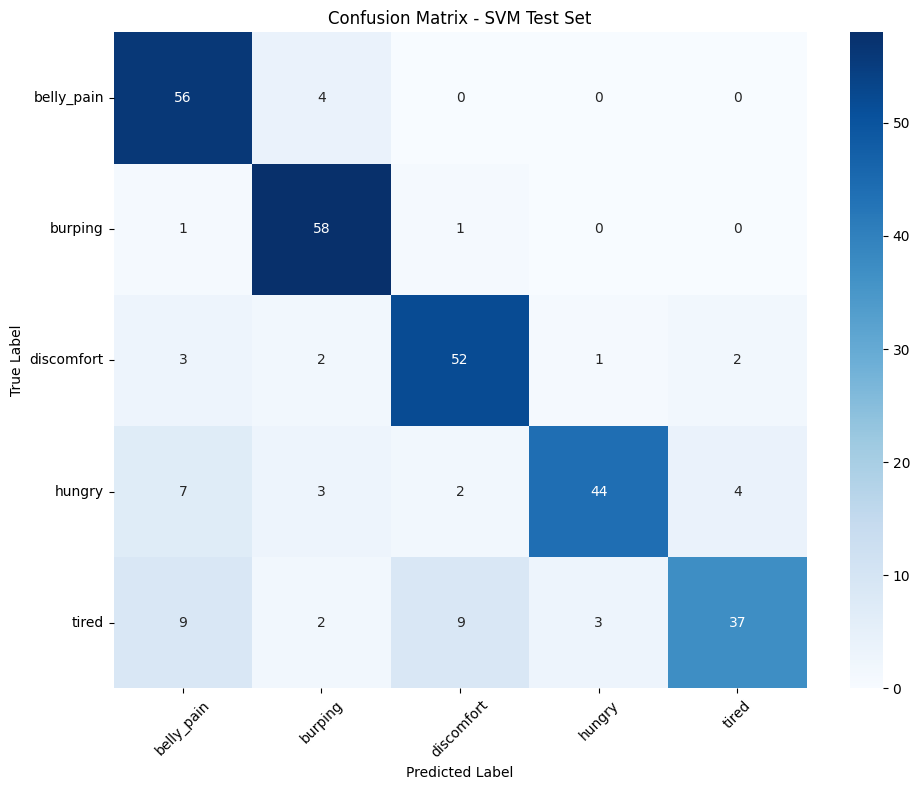


CONFUSION MATRIX:
            belly_pain  burping  discomfort  hungry  tired
belly_pain          56        4           0       0      0
burping              1       58           1       0      0
discomfort           3        2          52       1      2
hungry               7        3           2      44      4
tired                9        2           9       3     37

AKURASI PER KELAS:
belly_pain: 0.9333 (56/60)
burping: 0.9667 (58/60)
discomfort: 0.8667 (52/60)
hungry: 0.7333 (44/60)
tired: 0.6167 (37/60)


In [16]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_test_pred)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=label_mapping, yticklabels=label_mapping)
plt.title('Confusion Matrix - SVM Test Set')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Tampilkan confusion matrix dalam bentuk tabel
print("\nCONFUSION MATRIX:")
print("=" * 50)
cm_df = pd.DataFrame(cm, index=label_mapping, columns=label_mapping)
print(cm_df)

# Hitung dan tampilkan akurasi per kelas
print("\nAKURASI PER KELAS:")
print("=" * 50)
class_accuracies = cm.diagonal() / cm.sum(axis=1)
for i, class_name in enumerate(label_mapping):
    print(f"{class_name}: {class_accuracies[i]:.4f} ({cm.diagonal()[i]}/{cm.sum(axis=1)[i]})")

## 7. Results Analysis

### 7.1 Model Summary

In [17]:
print("\n8. ANALISIS RESULTS...")
print("=" * 80)
print("RINGKASAN HASIL MODEL")
print("=" * 80)

print(f"Dataset Information:")
print(f"  Training samples: {X_train.shape[0]}")
print(f"  Validation samples: {X_val.shape[0]}")
print(f"  Test samples: {X_test.shape[0]}")
print(f"  Number of features: {X_train.shape[1]}")
print(f"  Number of classes: {len(label_mapping)}")
print(f"  Classes: {list(label_mapping)}")

print(f"\nBest Model Configuration:")
for param, value in best_overall_params.items():
    print(f"  {param}: {value}")

print(f"\nModel Performance:")
print(f"  Best Validation Accuracy: {best_overall_score:.4f}")
print(f"  Final Test Accuracy: {test_accuracy:.4f}")
print(f"  Training Time: {final_train_time:.2f} seconds")
print(f"  Prediction Time: {prediction_time:.4f} seconds")


8. ANALISIS RESULTS...
RINGKASAN HASIL MODEL
Dataset Information:
  Training samples: 1400
  Validation samples: 300
  Test samples: 300
  Number of features: 34
  Number of classes: 5
  Classes: [np.str_('belly_pain'), np.str_('burping'), np.str_('discomfort'), np.str_('hungry'), np.str_('tired')]

Best Model Configuration:
  kernel: rbf
  C: 10.0
  gamma: 0.1
  max_iter: 500
  tol: 0.001
  eps: 0.001

Model Performance:
  Best Validation Accuracy: 0.8267
  Final Test Accuracy: 0.8233
  Training Time: 141.81 seconds
  Prediction Time: 0.1225 seconds


### 7.2 Support Vectors Analysis

In [18]:
# Informasi tentang support vectors untuk setiap binary classifier
print(f"\nSupport Vectors Information:")
total_support_vectors = 0
for class_label in final_model.classes:
    classifier = final_model.classifiers[class_label]
    n_sv = len(classifier.support_vectors) if hasattr(classifier, 'support_vectors') else 0
    total_support_vectors += n_sv
    print(f"  Class {label_mapping[class_label]}: {n_sv} support vectors")
    
print(f"  Total support vectors: {total_support_vectors}")
print(f"  Support vector ratio: {total_support_vectors/(X_train.shape[0]*len(label_mapping)):.4f}")


Support Vectors Information:
  Class belly_pain: 438 support vectors
  Class burping: 431 support vectors
  Class discomfort: 524 support vectors
  Class hungry: 676 support vectors
  Class tired: 562 support vectors
  Total support vectors: 2631
  Support vector ratio: 0.3759


## 8. Save Model

### 8.1 Package and Save Model

In [19]:
print("\n9. SIMPAN MODEL...")

# Simpan best model
model_filename = 'best_svm_model.pkl'

# Buat dictionary untuk menyimpan semua informasi model
model_package = {
    'model': final_model,
    'best_params': best_overall_params,
    'validation_accuracy': best_overall_score,
    'test_accuracy': test_accuracy,
    'label_mapping': label_mapping,
    'feature_names': feature_names,
    'training_time': final_train_time,
    'prediction_time': prediction_time,
    'grid_search_results': {
        'linear_results': linear_results,
        'rbf_results': rbf_results
    }
}

# Simpan model
with open(model_filename, 'wb') as f:
    pickle.dump(model_package, f)

print(f"Model berhasil disimpan sebagai '{model_filename}'")
print(f"\nUntuk memuat model:")
print(f"with open('{model_filename}', 'rb') as f:")
print(f"    model_package = pickle.load(f)")
print(f"    model = model_package['model']")
print(f"    best_params = model_package['best_params']")


9. SIMPAN MODEL...
Model berhasil disimpan sebagai 'best_svm_model.pkl'

Untuk memuat model:
with open('best_svm_model.pkl', 'rb') as f:
    model_package = pickle.load(f)
    model = model_package['model']
    best_params = model_package['best_params']


### 8.2 Final Summary

In [20]:
print("\n" + "=" * 80)
print("IMPLEMENTASI SVM SELESAI!")
print("=" * 80)
print(f"✅ Dataset berhasil dimuat dan diproses")
print(f"✅ SVM from scratch dengan SMO algorithm berhasil diimplementasi")
print(f"✅ One-vs-Rest multiclass classification berhasil diimplementasi")
print(f"✅ Grid search hyperparameter tuning berhasil dilakukan")
print(f"✅ Model evaluation dengan berbagai metrik berhasil dilakukan")
print(f"✅ Best model berhasil disimpan dalam format .pkl")
print(f"\nFinal Test Accuracy: {test_accuracy:.4f}")
print(f"Best Parameters: {best_overall_params}")
print("=" * 80)


IMPLEMENTASI SVM SELESAI!
✅ Dataset berhasil dimuat dan diproses
✅ SVM from scratch dengan SMO algorithm berhasil diimplementasi
✅ One-vs-Rest multiclass classification berhasil diimplementasi
✅ Grid search hyperparameter tuning berhasil dilakukan
✅ Model evaluation dengan berbagai metrik berhasil dilakukan
✅ Best model berhasil disimpan dalam format .pkl

Final Test Accuracy: 0.8233
Best Parameters: {'kernel': 'rbf', 'C': 10.0, 'gamma': 0.1, 'max_iter': 500, 'tol': 0.001, 'eps': 0.001}
